#### 0. Import the data and declare your package dependencies.

In [1]:
import numpy as np
import pandas as pd
from plotnine import * 
df = pd.read_csv('avocado2020.csv')

#### 1. Briefly describe the data set. What information does it contain?
The dataset contains information of 
- date: the date of the observation
- average_price: the average price of a single avocado
- total_volume: total number of avocados sold
- 4046/4225/4770: total number of avocados with PLU 4046, 4225 and 4770 sold
- type: the type of avocado(conventional organic)
- year: the year
- geography: the geography
- small_bags / large_bags / xlarge_bags / total_bags: number of difference sizes of bags and total number of bags

#### 2. Clean the data in any way you see fit.

In [2]:
# Clean the data
# Separate the geography column into major regions and metro regions
avocado_clean = df.copy()

avocado_clean['major_regions'] = avocado_clean['geography'].apply(lambda x: x if x in ['Great Lakes', 'Midsouth', 'Northeast', 'Northern New England', 'South Central', 'Southeast', 'West'] else None)
avocado_clean['States'] = avocado_clean['geography'].apply(lambda x: x if x in ['California', 'South Carolina'] else None)
avocado_clean['National'] = avocado_clean['geography'].apply(lambda x: x if x in ['Total U.S.'] else None)
avocado_clean['metro_regions'] = avocado_clean['geography'].apply(lambda x: None if x in ['Total U.S.', 'California', 'South Carolina', 'Great Lakes', 'Midsouth', 'Northeast', 'Northern New England', 'South Central', 'Southeast', 'West'] else x)

In [3]:
# rename 4046, 4220 and 4770 columns
avocado_clean.rename(columns={'4046' : 'small avocados',
                   '4225' : 'large avocados',
                   '4770' : 'extra large avocados'}, inplace = True)

#### 3. Which major geographical region sold the most total organic, small Hass avocados in 2017?

In [4]:
avocado_clean['date'] = pd.to_datetime(avocado_clean['date'])
a_filter = avocado_clean[(avocado_clean['major_regions'].notna()) & 
                         (avocado_clean['date'].dt.year == 2017) & 
                         (avocado_clean['type']== 'organic')]


a_result = a_filter[['date', 'small avocados', 'type', 'major_regions']]

max_small_avocados = a_result['small avocados'].idxmax()
max_row = a_result.loc[max_small_avocados]
max_row

date              2017-02-19 00:00:00
small avocados              127051.75
type                          organic
major_regions               Northeast
Name: 12046, dtype: object

Northeast region sold the most total organic, small Hass avocado in 2017

#### 4. Split the date variable into month, day, and year variables. In which month is the highest average volume of avocado sales?

In [5]:
avocado_clean['day'] = avocado_clean['date'].dt.day
avocado_clean['month'] = avocado_clean['date'].dt.month
avocado_clean['year'] = avocado_clean['date'].dt.year
avocado_clean = avocado_clean.drop(columns=['date'])

# Reorder the columns 
cols_to_move = ['year', 'month', 'day']
other_cols = [col for col in avocado_clean.columns if col not in cols_to_move]
new_column_order = cols_to_move + other_cols
avocado_clean = avocado_clean[new_column_order]

In [6]:
pd.set_option('display.float_format', '{:.2f}'.format)
average_volume = avocado_clean.groupby('month')['total_volume'].mean()
highest_month = average_volume.nlargest(1)
highest_month

month
5   1123632.25
Name: total_volume, dtype: float64

May has the highest average volumn of avocado sales

#### 5. Which metro area geographical regions sold the most total avocados? Plot side-by-side box-plots of the total volume for only the five metro geographical regions with the highest averages for the total_volume variable.

In [7]:
a_filter2 = avocado_clean[(avocado_clean['metro_regions'].notna())]
total_by_region = a_filter2.groupby('metro_regions')['total_volume'].sum()

pd.set_option('display.float_format', '{:.2f}'.format)
highest = total_by_region.nlargest(1)
highest

metro_regions
Los Angeles   959350488.02
Name: total_volume, dtype: float64

California sold the most total avocados

In [8]:
pd.set_option('display.float_format', '{:.2f}'.format)
average_volume = a_filter2.groupby('metro_regions')['total_volume'].mean()
top_5_metro_regions = average_volume.nlargest(5)
top_5_metro_regions

metro_regions
Los Angeles        1567566.16
Plains             1038002.64
New York            863145.82
Dallas/Ft. Worth    712751.90
Houston             687653.34
Name: total_volume, dtype: float64

C:\Users\tcjen\AppData\Local\Temp\ipykernel_9348\560740596.py:11: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


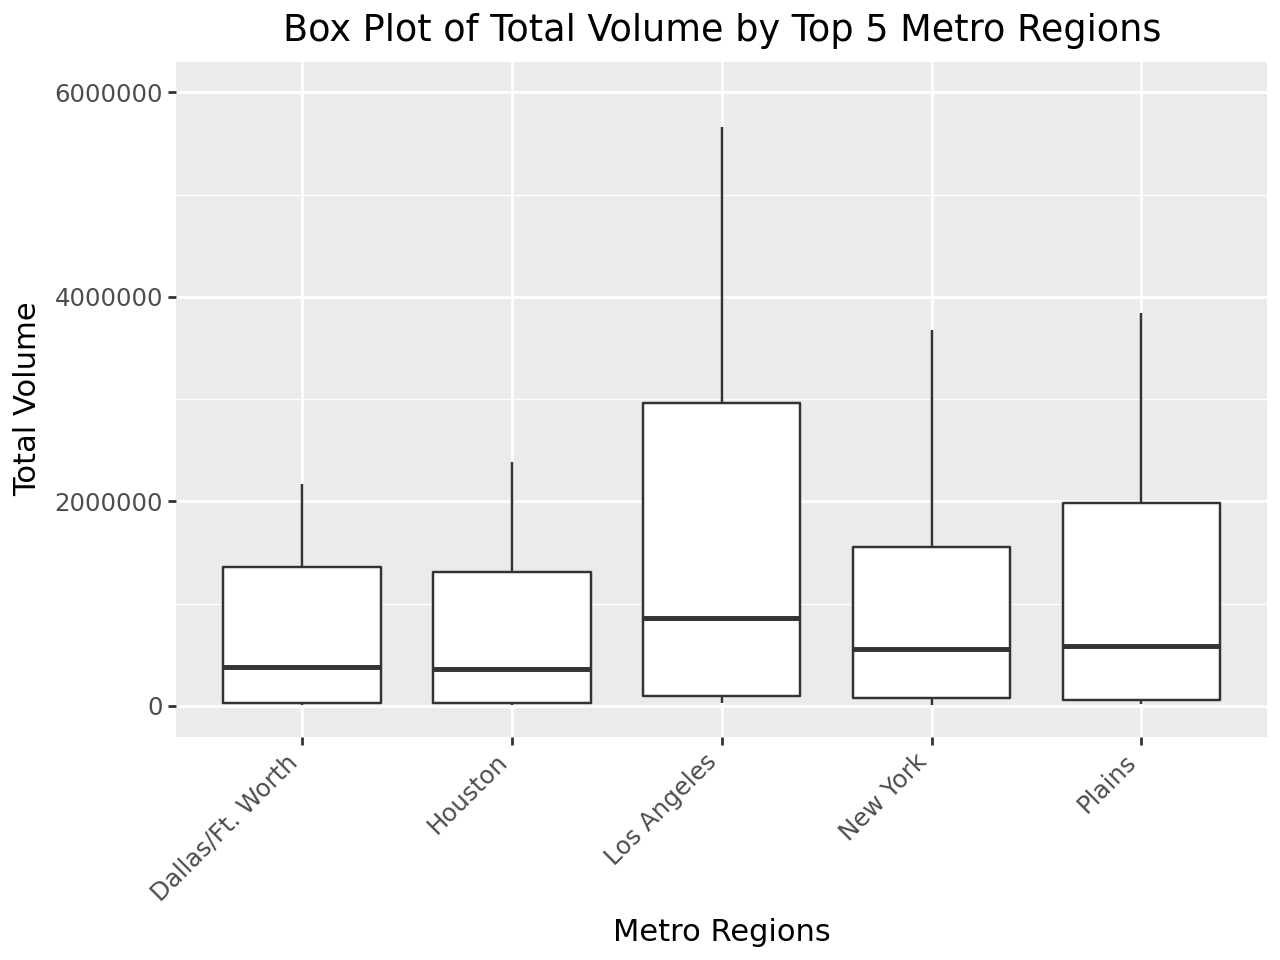

In [19]:
top_5_metro_regions = average_volume.nlargest(5).index.tolist()

filtered_data = a_filter2[a_filter2['metro_regions'].isin(top_5_metro_regions)]
box_plot = (
    ggplot(filtered_data, aes(x='metro_regions', y='total_volume')) +
    geom_boxplot() +
    labs(title='Box Plot of Total Volume by Top 5 Metro Regions',
         x='Metro Regions',
         y='Total Volume') +
    theme(axis_text_x=element_text(rotation=45, hjust=1)) + ylim(0, 6000000))
print(box_plot)

#### 6. From your cleaned data set, create a data set with only these California regions and answer the following questions about these California regions only.

In [9]:
cities = ['Los Angeles', 'Sacramento', 'San Diego', 'San Francisco']
ca_dataset = avocado_clean[avocado_clean['metro_regions'].isin(cities)].copy()

#### 7. In which California regions is the price of organic versus conventional avocados most different? Support your answer with a few summary statistics AND a visualization.

In [10]:
price_summary = ca_dataset.groupby(['metro_regions', 'type'])['average_price'].mean().unstack()
price_summary['price_difference'] = abs(price_summary['organic'] - price_summary['conventional'])
price_summary

type,conventional,organic,price_difference
metro_regions,,,
Los Angeles,1.05,1.57,0.53
Sacramento,1.30,1.87,0.58
San Diego,1.11,1.80,0.68
San Francisco,1.40,2.12,0.72


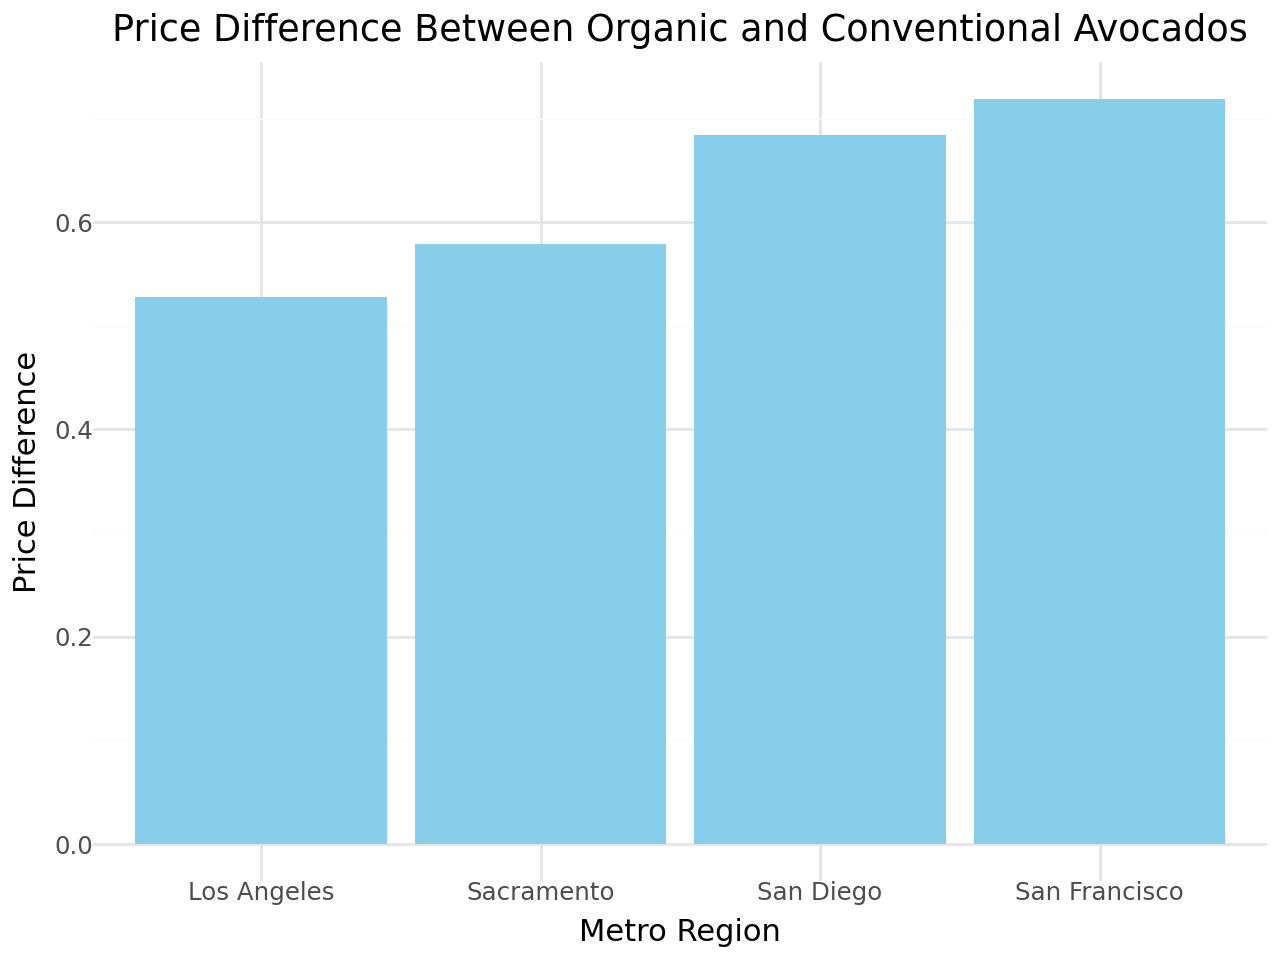

In [21]:
price_diff = (ggplot(price_summary.reset_index(), aes(x='metro_regions', y='price_difference')) +
                   geom_bar(stat='identity', fill='skyblue') +
                   labs(title='Price Difference Between Organic and Conventional Avocados',
                        x='Metro Region', y='Price Difference') +
                   theme_minimal())
price_diff

San Francisco's price difference between organic and conventional has the most different

#### 8. The following plot shows, for all four California regions, the proportion of the average Hass avocado sales that are small, large, or extra large; conventional vs. organic. Recreate the plot; you do not have to replicate the exact finishing touches - e.g., color, theme - but your plot should resemble the content of this plot.

In [11]:
ca_dataset['small'] = ca_dataset['small avocados'] / ca_dataset['total_volume']
ca_dataset['large'] = ca_dataset['large avocados'] / ca_dataset['total_volume']
ca_dataset['xlarge'] = ca_dataset['extra large avocados'] / ca_dataset['total_volume']
summary = ca_dataset.groupby(['metro_regions', 'type'])[['small', 'large', 'xlarge']].sum().reset_index()

In [12]:
from pandas.api.types import CategoricalDtype
summary_melted = pd.melt(summary, id_vars=['metro_regions', 'type'], 
                         value_vars=['small', 'large', 'xlarge'], 
                         var_name='size', value_name='sales')
size_order = CategoricalDtype(['xlarge', 'large', 'small'], ordered=True)
summary_melted['size'] = summary_melted['size'].astype(size_order)
summary_melted['proportion'] = summary_melted.groupby(['metro_regions', 'type'])['sales'].transform(lambda x: x / x.sum())

C:\Users\tcjen\AppData\Local\Temp\ipykernel_9348\2606145533.py:8: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


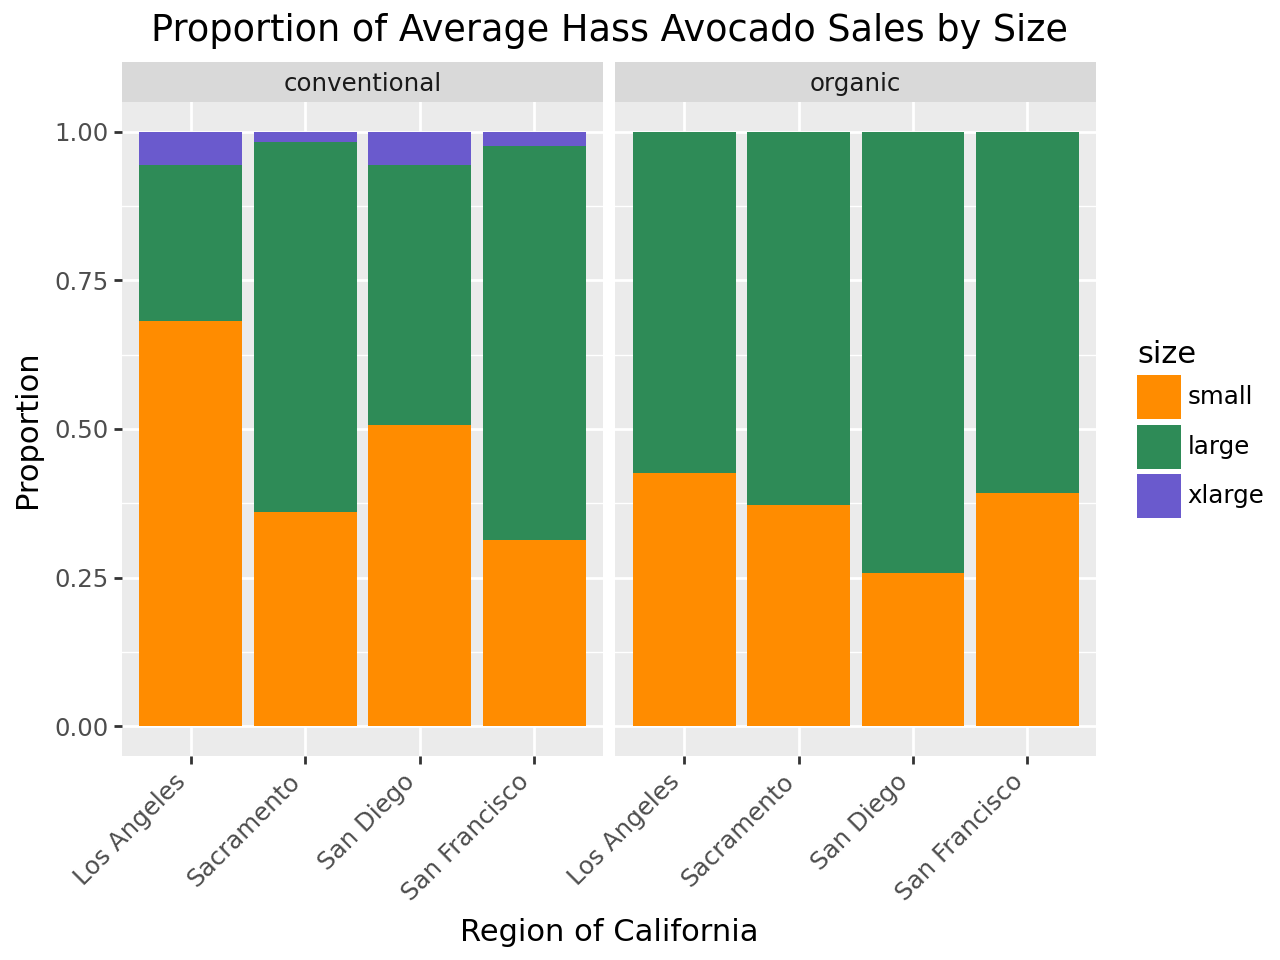

In [23]:
plot = (ggplot(summary_melted, aes(x='metro_regions', y='proportion', fill='size')) +
        geom_bar(stat='identity', position='fill') +
        facet_wrap('~type') +
        labs(x='Region of California', y='Proportion', 
             title='Proportion of Average Hass Avocado Sales by Size') +
        scale_fill_manual(values=["#FF8C00", "#2E8B57", "#6A5ACD"], breaks=['small', 'large', 'xlarge']) +  
        theme(axis_text_x=element_text(rotation=45, hjust=1)))
print(plot)

#### Find or make a data set with house prices for these four California regions. Join this data set with your California avocado data set.

#### Use your new joined data set to make an argument about the relationship between house prices and avocado prices/sales.

#### Support your argument with a plot.

In [14]:
summary2 = ca_dataset.groupby(['metro_regions', 'year'])[['total_volume']].sum().reset_index().copy()
summary2.head()

,metro_regions,year,total_volume
0,Los Angeles,2015,148220692.98
1,Los Angeles,2016,163142302.82
2,Los Angeles,2017,158481174.24
3,Los Angeles,2018,150961956.80
4,Los Angeles,2019,163162613.60


Based on Zillow and Redfin, got the average price for the four cities from 2015 to 2020
 

In [15]:
houseprice = pd.read_csv('Housing Price.csv')
summary2['Housing Price'] = houseprice['House price']
summary2.head()

,metro_regions,year,total_volume,Housing Price
0,Los Angeles,2015,148220692.98,533000
1,Los Angeles,2016,163142302.82,565000
2,Los Angeles,2017,158481174.24,605000
3,Los Angeles,2018,150961956.80,643000
4,Los Angeles,2019,163162613.60,683000


In [16]:
# melt the data for plotting
summary2 = summary2.melt(
    id_vars=['year', 'metro_regions'], 
    value_vars=['total_volume', 'Housing Price'],  
    var_name='Metric',  
    value_name='Value'  
)

C:\Users\tcjen\AppData\Local\Temp\ipykernel_9348\3271806354.py:7: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


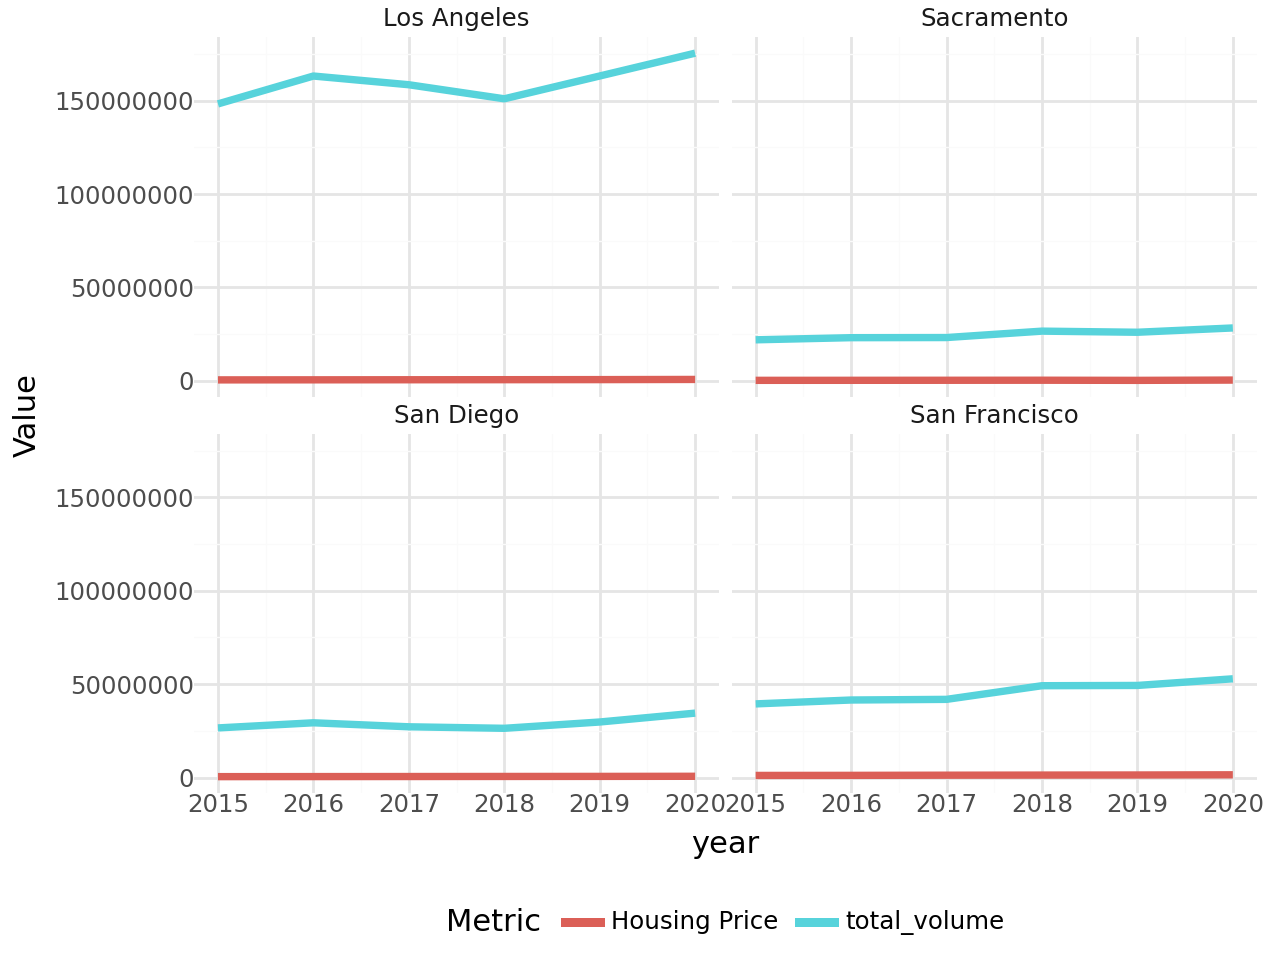

In [25]:
plot = (
    ggplot(summary2, aes(x='year', y='Value', color='Metric'))
    + geom_line(size=1.5, linetype="solid")
    + facet_wrap('metro_regions')
    + theme_minimal()
    + theme(legend_position='bottom') )
print(plot)


Based on the plots shown above, housing price and avocado sales don't seem to have a obvious relationship, so no matter what the housing price is, people still buy avocados 